In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats
library(mltools)
library(data.table)
library(VIM)
library(lubridate)
library(caret)
library(CatEncoders)
library(ROSE)
library(catboost)
library(UBL)
library(DMwR)
# package for pr.curve
library(PRROC)
library(ROCR)
library(gbm)
library(xgboost)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(jsonlite)
library(stringr)
library(feather)
#group_by
library(dplyr)
#plot, ggplot
library(ggplot2)
library(ggpubr)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

print("Reading in files and addressing JSON data...")
#assign correct data types and appropriate column names 
col_types <- cols(
  channelGrouping = col_character(),
  customDimensions = col_character(),
  date = col_datetime(), # Parses YYYYMMDD
  #date = col_integer(), #lets do the conversion later after ROSE
  device = col_character(),
  fullVisitorId = col_character(),
  geoNetwork = col_character(),
  hits = col_skip(), # MASSIVE amount of data!
  #sessionId = col_character(), # not present in v2 comp; not used anwyay
  socialEngagementType = col_skip(), # Skip as always "Not Socially Engaged"
  totals = col_character(),
  trafficSource = col_character(),
  visitId = col_skip(), # visitId & visitStartTime look identical in all but 5000 cases
  visitNumber = col_integer(),
  visitStartTime = col_skip() # Convert to POSIXlt later,
  #visitStartTime = col_datetime()
  )
# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")
train <- read_csv("../input/ga-customer-revenue-prediction/train_v2.csv", col_types = col_types) 
test <- read_csv("../input/ga-customer-revenue-prediction/test_v2.csv",  col_types = col_types)

#which columns includes JSON, JSON-like data
#JSON columns are "device", "geoNetwork", "totals", "trafficSource", "customDimensions"
unsnake <- . %>%
  str_replace_all(c("\\[\\]" = "[{}]", # empty element must contain dictionary
                    "^\\[|\\]$" = "", # remove initial and final brackets
                    "(\\[|\\{|, |: |', )'" = "\\1\"", # open single- to double-quote (on key or value)
                    "'(\\]|\\}|: |, )" = '\"\\1')) # close quote

tr_device <- paste("[", paste(train$device, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_geoNetwork <- paste("[", paste(train$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_totals <- paste("[", paste(train$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_trafficSource <- paste("[", paste(train$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

tr_customDimensions <- paste("[", paste(unsnake(train$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

te_device <- paste("[", paste(test$device, collapse = ","), "]") %>% fromJSON(flatten = T)
te_geoNetwork <- paste("[", paste(test$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
te_totals <- paste("[", paste(test$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
te_trafficSource <- paste("[", paste(test$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

te_customDimensions <- paste("[", paste(unsnake(test$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

#Combine to make the full training and test sets. campaignCode in train is dropped.
flat.train <- train %>%
    cbind(tr_device, tr_geoNetwork, tr_totals, tr_trafficSource, tr_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions, -campaignCode)
    
    
flat.test <- test %>%
    cbind(te_device, te_geoNetwork, te_totals, te_trafficSource, te_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions)

#Remove temporary tr_ and te_ sets
rm(tr_device); rm(tr_geoNetwork); rm(tr_totals); rm(tr_trafficSource); rm(tr_customDimensions)
rm(te_device); rm(te_geoNetwork); rm(te_totals); rm(te_trafficSource); rm(te_customDimensions)

flat.train.red <- flat.train %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index, 
          -adwordsClickInfo.gclId, -metro, -transactions, -transactionRevenue, -keyword, 
           -referralPath, -adContent, -campaign, -adwordsClickInfo.page, -adwordsClickInfo.slot, 
           -adwordsClickInfo.adNetworkType)

flat.test.red <- flat.test %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index,
          -adwordsClickInfo.gclId, -metro, -transactions, -transactionRevenue, -keyword, 
           -referralPath, -adContent, -campaign, -adwordsClickInfo.page, -adwordsClickInfo.slot, 
           -adwordsClickInfo.adNetworkType)

#setequal(names(flat.train.red), names(flat.test.red))
## Saving data
#write.csv(flat.train.red, "train_flat.csv", row.names = F)
#write.csv(flat.test.red, "test_flat.csv", row.names = F)

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

Loading required package: colorspace

Loading required package: grid

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:base’:

    date


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘CatEncoders’


The following object is masked from ‘package:base’:

    transform


Loaded ROSE 0.0-3


Loading required package: MBA

Loading required package: gs

[1] "Reading in files and addressing JSON data..."


In [ ]:
# In case we want to proceed with a subset of train data
set.seed(123)
train.subset <- split(flat.train.red, sample(1:10, nrow(flat.train.red), replace=T))
i = 1

dup_train <- as.data.frame(train.subset[i], col.names = names(c("channelGrouping", "date", 
"fullVisitorId", "visitNumber", "browser",
"operatingSystem", "isMobile", "deviceCategory", "continent", "subContinent", "country",
"city", "region", "networkDomain", "hits", "pageviews", "sessionQualityDim", "timeOnSite",
"totalTransactionRevenue", "source", "medium", "value")))

In [2]:
print("Data preparation...")
#----------------------------------
dup_train <- flat.train.red
dup_test <- flat.test.red

#print("Combining train and test samples...")
dup_train <- rbind(dup_train, dup_test)
str(dup_train)
#attributes type conversion
#dup_train$visitId <- as.character(dup_train$visitId)
# Numeric type conversion
cols.nam <- c("visitNumber", "hits","pageviews","sessionQualityDim","timeOnSite",
             "totalTransactionRevenue")
dup_train[cols.nam] <- sapply(dup_train[cols.nam],as.numeric)
#----------------------------------------
#print("Removing near-zero variance attributes...")
##nzv <- nearZeroVar(dup_train)
##dup_train <- dup_train[, -nzv]

##print("Identifying highly correlated attributes...")
##train.cor <-  cor(select_if(dup_train, is.numeric), use = "complete.obs")
##high.cor.att <- findCorrelation(train.cor, cutoff = .75, names=TRUE)#to drop pageviews and transactionRevenue

# pageviews and transactionRevenue highly correlated with hits and totalTransactionRevenue recpectively
# The dataset data dictionary also suggests using totalTransactionRevenue instead of transactionRevenue 
# as it is deprecated.
#high.cor.att # lets keep pageviews
#dup_train <- select(dup_train, -c(all_of(high.cor.att)))

##dup_train <- select(dup_train, -transactionRevenue)
#-----------------------------------------
print("Missing Values Ratio...")
#-----------------------------------------
funcMissRatio <- function(x, y){
    n <- vector()
    n <- rep(NA, length(x))
    missRatio <- cbind(x, n)

    for (i in 1:length(x)){
        y[x[i]][y[x[i]] == "(not set)"] <- NA
        y[x[i]][y[x[i]] == "not available in demo dataset"] <- NA
        y[x[i]][y[x[i]] == "unknown.unknown"] <- NA
        y[x[i]][y[x[i]] == "(none)"] <- NA
        y[x[i]][y[x[i]] == "(not provided)"] <- NA
        missRatio[i, 2] <- sum(is.na(y[x[i]]))/nrow(y)*100
    }
    print(missRatio)
    return(y)
}
# Start we geographical data as we will use it for further impute other attributes NAs, e.g., continent, subContinent
cols.nam <- c("continent", "subContinent", "country", "city", "region", "networkDomain")
dup_train <- funcMissRatio(cols.nam, dup_train)
#--------------------------------------------
print("Imputing NAs...")
#if all geo data are NA in the row
dup_train$continent[which(is.na(dup_train$networkDomain)&is.na(dup_train$city)& is.na(dup_train$metro)
    &is.na(dup_train$region)&is.na(dup_train$country) 
    &is.na(dup_train$continent)& is.na(dup_train$subContinent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#------------------------------------------
#region, city, networkDomain for some continent == NA are available
#from those we can extract continent value
temp <- dup_train %>%
    group_by(region) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$region)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$region)),
                                c("region")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.region.."))
nullatt <- rename(nullatt, c("region" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.region...."))

nullatt <- merge(temp, nullatt, by = c("region")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$region)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#------------------------------------------
temp <- dup_train %>%
    group_by(city) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$city)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$city)),
                                c("city")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.city.."))
nullatt <- rename(nullatt, c("city" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.city...."))

nullatt <- merge(temp, nullatt, by = c("city")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$city)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#-------------------------------------------
temp <- dup_train %>%
    group_by(networkDomain) %>%
    filter(!is.null(names(which.max(table(continent[!is.na(continent)]))))&!is.na(continent)) %>% #some networkDomain groups has no corresponding 
# continent result in NULL value, we filter them out to avoid error in summarize
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), 
                      dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), c("networkDomain")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.networkDomain.."))
nullatt <- rename(nullatt, c("networkDomain" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.networkDomain...."))

nullatt <- merge(temp, nullatt, by = c("networkDomain")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#----------------------------------------------
# The corresponding networkDomain data do not provide any geo info, we may want to set them to NA
dup_train$continent[which(is.na(dup_train$continent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#-----------------------------------------------
#subContinent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(subContinent)) %>%
    summarize(maxlevel = names(which.max(table(subContinent[!is.na(subContinent)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$subContinent)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$subContinent))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.subContinent.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$subContinent)), nullatt$narows)

dup_train$subContinent[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$subContinent))
#--------------------------------------------
#country
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(country)) %>%
    summarize(maxlevel = names(which.max(table(country[!is.na(country)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$country)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$country))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.country.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$country[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$country))
#---------------------------------------------
#networkDomain
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
# Second round to addess NAs based on continent
# if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
#----------------------------------------
#city
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
#---------------------------------------------
print("Missing Values Ratio...")
# Computing NA ratio
cols.nam <- c("visitNumber", "hits", "pageviews", "sessionQualityDim", "timeOnSite")
dup_train <- funcMissRatio(cols.nam, dup_train)
#pageviews
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(pageviews)) %>%
    summarize(meanatt = mean(pageviews))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$pageviews)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$pageviews))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.pageviews.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$pageviews[nullatt$narows] <- nullatt$meanatt
sum(is.na(dup_train$pageviews))
# sessionQualityDim
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
# The second round to addess NAs based on continent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

#sum(is.na(dup_train$sessionQualityTime))
which(is.na(dup_train$sessionQualityTime))
nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
#----------------------------------------
#timeOnSite
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#sum(is.na(dup_train$timeOnSite))
#if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#---------------------------------------
# channelGrouping NAs: no NA but has (Other) level
dup_train %>% 
  filter(!is.na(channelGrouping)) %>%
  count(channelGrouping, sort = TRUE)
#----------------------------------------
print("Missing Values Ratio...")
cols.nam <- c("operatingSystem","browser","isMobile","deviceCategory")
dup_train <- funcMissRatio(cols.nam, dup_train)
#-----------------------------------------------
# operatingSystem
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory) %>%
    filter(!is.na(operatingSystem)) %>%
    summarize(maxlevel = names(which.max(table(operatingSystem[!is.na(operatingSystem)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$operatingSystem)),
                                c("totalTransactionRevenue", "deviceCategory")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$operatingSystem))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.operatingSystem.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$operatingSystem)), nullatt$narows)

dup_train$operatingSystem[nullatt$narows] <- nullatt$maxlevel
#----------------------------------------
# browser
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory, operatingSystem) %>%
    filter(!is.na(browser)) %>%
    summarize(maxlevel = names(which.max(table(browser[!is.na(browser)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$browser)),
                                c("totalTransactionRevenue", "deviceCategory", "operatingSystem")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$browser))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.browser.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory", "operatingSystem")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$browser[nullatt$narows] <- nullatt$maxlevel
#--------------------------------------
#str(dup_train)
print("Missing Values Ratio...")
cols.nam <- c("source", "medium", "value")
dup_train <- funcMissRatio(cols.nam, dup_train)
#------------------------------------------------
# source
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(source)) %>%
    summarize(maxlevel = names(which.max(table(source[!is.na(source)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$source)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$source))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.source.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$source[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$source))
#----------------------------------------------------
#medium
# We can address NAs at country then subContinent and finally continent level
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$medium))
#-----------------------------------------------------
# value
#dup_train$value[dup_train$value == "(not set)"] <- NA
#missRatio <- sum(is.na(dup_train$value))/nrow(dup_train)*100
#missRatio

temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Addressing a few remaining NAs in value
dup_train$value[which(is.na(dup_train$value))] <- names(which.max(table(dup_train$value[!is.na(dup_train$value)])))
#sum(is.na(dup_train$value))
print("Checking if all interesting attributes NAs have been addressed...")
cols.nam <- c("visitNumber","hits","pageviews", "sessionQualityDim","timeOnSite","totalTransactionRevenue",
              "operatingSystem","browser","isMobile","deviceCategory", 
              "continent", "subContinent", "country", "region", "city", "networkDomain", 
            "source", "medium", "value")

dup_train <- funcMissRatio(cols.nam, dup_train)

[1] "Data preparation..."
'data.frame':	2109926 obs. of  22 variables:
 $ channelGrouping        : chr  "Organic Search" "Referral" "Direct" "Organic Search" ...
 $ date                   : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : chr  "3162355547410993243" "8934116514970143966" "7992466427990357681" "9075655783635761930" ...
 $ visitNumber            : int  1 6 1 1 1 1 1 1 1 2 ...
 $ browser                : chr  "Firefox" "Chrome" "Chrome" "Chrome" ...
 $ operatingSystem        : chr  "Windows" "Chrome OS" "Android" "Windows" ...
 $ isMobile               : logi  FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ deviceCategory         : chr  "desktop" "desktop" "mobile" "desktop" ...
 $ continent              : chr  "Europe" "Americas" "Americas" "Asia" ...
 $ subContinent           : chr  "Western Europe" "Northern America" "Northern America" "Western Asia" ...
 $ country                : chr  "Germany" "United States" "United States" "Turkey" ...
 $ region

[1] 0

integer(0)

channelGrouping,n
<chr>,<int>
Organic Search,937341
Social,391852
Direct,349210
Referral,270812
Paid Search,58461
Display,58359
Affiliates,43748
(Other),143


[1] "Missing Values Ratio..."
     x                 n                     
[1,] "operatingSystem" "0.767657254330247"   
[2,] "browser"         "0.000568740325490088"
[3,] "isMobile"        "0"                   
[4,] "deviceCategory"  "0"                   
[1] "Missing Values Ratio..."
     x        n                    
[1,] "source" "0.00331765189869218"
[2,] "medium" "32.105580954024"    
[3,] "value"  "18.6649200019337"   
[1] "Checking if all interesting attributes NAs have been addressed..."
      x                         n                 
 [1,] "visitNumber"             "0"               
 [2,] "hits"                    "0"               
 [3,] "pageviews"               "0"               
 [4,] "sessionQualityDim"       "0"               
 [5,] "timeOnSite"              "0"               
 [6,] "totalTransactionRevenue" "98.9047957132146"
 [7,] "operatingSystem"         "0"               
 [8,] "browser"                 "0"               
 [9,] "isMobile"                "0"

In [ ]:
# Visualizing some attrbibutes with 95% NAs...
str(dup_train)
test.data <- dup_train %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- dup_train %>%
    filter(ldate < as.Date("2018-05-01"))

# adwordsClickInfo.page has too many NAs, and the highest factor is the same for Rev and nonRev customer
# so imputing NAs won't make it any informative, low variance
data_zero_rev <- dup_train %>%
    select(adwordsClickInfo.page, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.page))

temp1 <- data_zero_rev %>%
    group_by(adwordsClickInfo.page) %>%
    summarize(pageCount = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr)) %>%
    filter(pageCount > 10)

data_notzero_rev <- dup_train %>%
    select(adwordsClickInfo.page, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.page))
table(data_zero_rev$adwordsClickInfo.page)
dim(data_zero_rev)
dim(data_notzero_rev)
temp2 <- data_notzero_rev %>%
    group_by(adwordsClickInfo.page) %>%
    summarize(pageCount = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr))  
#plots
g1 <- ggplot(temp1, aes(reorder(adwordsClickInfo.page, -pageCount), pageCount))
r1 <- g1 + geom_bar(stat="Identity") 
s1 <- r1 + coord_flip() + labs(title = "ZeroRev", x = "adwordsClickInfo.page", y = "#ofCustomers")

g2 <- ggplot(temp2, aes(reorder(adwordsClickInfo.page, -pageCount), pageCount))
r2 <- g2 + geom_bar(stat="Identity") 
s2 <- r2 + coord_flip() + labs(title = "NonZeroRev", x = "adwordsClickInfo.page", y = "#ofCustomers")

ggarrange(s1, s2, 
          labels = c("A", "B"),
          ncol = 1, nrow = 2)
#----------------------------------
data_zero_rev <- dup_train %>%
    select(adwordsClickInfo.slot, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.slot))

temp3 <- data_zero_rev %>%
    group_by(adwordsClickInfo.slot) %>%
    summarize(slotCount = n()) 

data_notzero_rev <- dup_train %>%
    select(adwordsClickInfo.slot, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.slot))

temp4 <- data_notzero_rev %>%
    group_by(adwordsClickInfo.slot) %>%
    summarize(slotCount = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr))

g3 <- ggplot(temp3, aes(reorder(adwordsClickInfo.slot, slotCount), slotCount))
r3 <- g3 + geom_bar(stat="Identity") 
s3 <- r3 + coord_flip() + labs(title = "ZeroRev", x = "adwordsClickInfo.slot", y = "#ofCustomers")

g4 <- ggplot(temp4, aes(reorder(adwordsClickInfo.slot, slotCount), slotCount))
r4 <- g4 + geom_bar(stat="Identity") 
s4 <- r4 + coord_flip() + labs(title = "NonZeroRev", x = "adwordsClickInfo.slot", y = "#ofCustomers")

ggarrange(s3, s4,
          labels = c("C", "D"),
          ncol = 1, nrow = 2)
#--------------------------------
data_zero_rev <- dup_train %>%
    select(adContent, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(adContent))

temp3 <- data_zero_rev %>%
    group_by(adContent) %>%
    summarize(Count = n()) %>%
    filter(Count > 1000)
data_notzero_rev <- dup_train %>%
    select(adContent, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(adContent))

temp4 <- data_notzero_rev %>%
    group_by(adContent) %>%
    summarize(Count = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr)) %>%
    filter(Count > 10)

g3 <- ggplot(temp3, aes(reorder(adContent, Count), Count))
r3 <- g3 + geom_bar(stat="Identity") 
s3 <- r3 + coord_flip() + labs(title = "ZeroRev", x = "adContent", y = "#ofCustomers")

g4 <- ggplot(temp4, aes(reorder(adContent, Count), Count))
r4 <- g4 + geom_bar(stat="Identity") 
s4 <- r4 + coord_flip() + labs(title = "NonZeroRev", x = "adContent", y = "#ofCustomers")

ggarrange(s3, s4,
          labels = c("C", "D"),
          ncol = 1, nrow = 2)
#-------------------------------------
data_zero_rev <- dup_train %>%
    select(adwordsClickInfo.adNetworkType, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.adNetworkType))

temp3 <- data_zero_rev %>%
    group_by(adwordsClickInfo.adNetworkType) %>%
    summarize(Count = n()) #%>%
    #filter(Count > 1000)
data_notzero_rev <- dup_train %>%
    select(adwordsClickInfo.adNetworkType, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(adwordsClickInfo.adNetworkType))

temp4 <- data_notzero_rev %>%
    group_by(adwordsClickInfo.adNetworkType) %>%
    summarize(Count = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr)) #%>%
    #filter(Count > 10)

g3 <- ggplot(temp3, aes(reorder(adwordsClickInfo.adNetworkType, Count), Count))
r3 <- g3 + geom_bar(stat="Identity") 
s3 <- r3 + coord_flip() + labs(title = "ZeroRev", x = "adwordsClickInfo.adNetworkType", y = "#ofCustomers")

g4 <- ggplot(temp4, aes(reorder(adwordsClickInfo.adNetworkType, Count), Count))
r4 <- g4 + geom_bar(stat="Identity") 
s4 <- r4 + coord_flip() + labs(title = "NonZeroRev", x = "adwordsClickInfo.adNetworkType", y = "#ofCustomers")

ggarrange(s3, s4,
          labels = c("C", "D"),
          ncol = 1, nrow = 2)
#-----------------------------------
# lots of NAs, the main group is "not set"
data_zero_rev <- dup_train %>%
    select(campaign, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(campaign))

temp3 <- data_zero_rev %>%
    group_by(campaign) %>%
    summarize(Count = n()) %>%
    filter(Count > 1000)
data_notzero_rev <- dup_train %>%
    select(campaign, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(campaign))

temp4 <- data_notzero_rev %>%
    group_by(campaign) %>%
    summarize(Count = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr)) %>%
    filter(Count > 50)

g3 <- ggplot(temp3, aes(reorder(campaign, Count), Count))
r3 <- g3 + geom_bar(stat="Identity") 
s3 <- r3 + coord_flip() + labs(title = "ZeroRev", x = "campaign", y = "#ofCustomers")

g4 <- ggplot(temp4, aes(reorder(campaign, Count), Count))
r4 <- g4 + geom_bar(stat="Identity") 
s4 <- r4 + coord_flip() + labs(title = "NonZeroRev", x = "campaign", y = "#ofCustomers")

ggarrange(s3, s4,
          labels = c("C", "D"),
          ncol = 1, nrow = 2)
#-----------------------------
data_zero_rev <- dup_train %>%
    select(keyword, totalTransactionRevenue) %>%
    filter(is.na(totalTransactionRevenue) & !is.na(keyword))

temp3 <- data_zero_rev %>%
    group_by(keyword) %>%
    summarize(Count = n()) %>%
    filter(Count > 1000)
data_notzero_rev <- dup_train %>%
    select(keyword, totalTransactionRevenue) %>%
    filter(!is.na(totalTransactionRevenue) & !is.na(keyword))

temp4 <- data_notzero_rev %>%
    group_by(keyword) %>%
    summarize(Count = n(), sttr = sum(totalTransactionRevenue), lnRev = log2(sttr)) %>%
    filter(Count > 50)

g3 <- ggplot(temp3, aes(reorder(keyword, Count), Count))
r3 <- g3 + geom_bar(stat="Identity") 
s3 <- r3 + coord_flip() + labs(title = "ZeroRev", x = "keyword", y = "#ofCustomers")

g4 <- ggplot(temp4, aes(reorder(keyword, Count), Count))
r4 <- g4 + geom_bar(stat="Identity") 
s4 <- r4 + coord_flip() + labs(title = "NonZeroRev", x = "keyword", y = "#ofCustomers")

ggarrange(s3, s4,
          labels = c("C", "D"),
          ncol = 1, nrow = 2)

In [3]:
print("Aggregating visitor level data...")
# Function to calculate each categorical attribute mode
catMode = function(x){
    y = names(which.max(table(x)))
    return(y)
} 
#-----------------------------------------
# Generating more attributes extracted from date e.g., day of the week, day of the month, month
#gc()
imbal.data <- dup_train
#rm("dup_train")
#gc()
imbal.data$month <- as.character(month(lubridate::as_datetime(imbal.data$date)))
imbal.data$mday <- as.character(mday(lubridate::as_datetime(imbal.data$date)))
imbal.data$wday <- as.character(wday(lubridate::as_datetime(imbal.data$date)))
#imbal.data$hour <- as.character(hour(lubridate::as_datetime(imbal.data$visitStartTime)))

imbal.data <- select(imbal.data, -c("region"))
#imbal.data <- select(imbal.data, -c("wday", "mday"))
imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
str(imbal.data)
#--------------------------------------------------
# transforming to visitor level data
temp1.imbal.data <- imbal.data %>%
filter(visitNumber == 1) 
temp1.imbal.data$freqVisit <- (rep(0, nrow(temp1.imbal.data)))
temp1.imbal.data$totalTransactionRevenue <- log1p(temp1.imbal.data$totalTransactionRevenue)
names(temp1.imbal.data)[names(temp1.imbal.data) == "date"] <- "ldate"

temp2.imbal.data <- imbal.data %>% 
group_by(fullVisitorId) %>%
filter(visitNumber != 1) %>%
summarize(channelGrouping = catMode(channelGrouping), visitNumber = max(visitNumber),
         ldate = max(date), browser = catMode(browser), operatingSystem = catMode(operatingSystem), 
         isMobile = catMode(isMobile), deviceCategory = catMode(deviceCategory), continent = catMode(continent), 
         subContinent = catMode(subContinent), country = catMode(country), city = catMode(city),
          networkDomain = catMode(networkDomain),
         hits = mean(hits), pageviews = mean(pageviews), sessionQualityDim = mean(sessionQualityDim), timeOnSite = mean(timeOnSite),
         totalTransactionRevenue = log1p(sum(totalTransactionRevenue)), source = catMode(source),
         medium = catMode(medium), value = catMode(value), month = catMode(month), mday = catMode(mday),
         wday = catMode(wday),
          freqVisit = as.numeric(max(date) - min(date))/max(visitNumber)
         )
temp2.imbal.data <- as.data.frame(temp2.imbal.data)

imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)

[1] "Aggregating visitor level data..."
'data.frame':	2109926 obs. of  24 variables:
 $ channelGrouping        : chr  "Organic Search" "Referral" "Direct" "Organic Search" ...
 $ date                   : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : chr  "3162355547410993243" "8934116514970143966" "7992466427990357681" "9075655783635761930" ...
 $ visitNumber            : num  1 6 1 1 1 1 1 1 1 2 ...
 $ browser                : chr  "Firefox" "Chrome" "Chrome" "Chrome" ...
 $ operatingSystem        : chr  "Windows" "Chrome OS" "Android" "Windows" ...
 $ isMobile               : logi  FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ deviceCategory         : chr  "desktop" "desktop" "mobile" "desktop" ...
 $ continent              : chr  "Europe" "Americas" "Americas" "Asia" ...
 $ subContinent           : chr  "Western Europe" "Northern America" "Northern America" "Western Asia" ...
 $ country                : chr  "Germany" "United States" "United States" "Turkey"

In [ ]:
# Visualizing totalTransactionRevenue per session vs. per visitor
# session level data
str(dup_train)
# visitor level data replacing totalTransactionRevenue with log1p(sum(totalTransactionRevenue))
str(imbal.data)
# This plot shows a highly imbalanced and skewed dataset
plot(sort(imbal.data$totalTransactionRevenue), main = "Revenue per Visitor", xlab = "Visitor Index", ylab = "Revenue")
#------------------------------------------------
# Now, let's see how the revenue changes over time and how aggregating data at visitor level changes the revenue trend
print("Plotting totalTransactionRevenue vs. date...")
# how log1p or visitor level data transform the dataset e.g., remove random errors, a ibt of seasonality
data.train <- dup_train %>%
  select(date, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))

temp1 <- data.train %>%
  group_by(date) %>%
  #summarize(bCount = n(), sttr = sum(log1p(totalTransactionRevenue))) 
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 

agg.data.train <- imbal.data %>%
  select(ldate, totalTransactionRevenue) %>%
  filter(totalTransactionRevenue != 0)

temp2 <- agg.data.train %>%
  group_by(ldate) %>%
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 
  

g1 <- ggplot(temp1, aes(date, sttr))
r1 <- g1 + geom_line() 
s1 <- r1 + labs(title = "Train", x = "Date", y = "totalTransactionRevenue")

g2 <- ggplot(temp2, aes(ldate, sttr))
r2 <- g2 + geom_line() 
s2 <- r2 + labs(title = "Train", x = "Date", y = "totalTransactionRevenue")

ggarrange(s1, s2,
          labels = c("A", "B"),
          ncol = 1, nrow = 2)
# data is changing in unforween patterns over time, not a trend or repetative pattern that occurs every year
# concept drift? update the model with the most recent data
#----------------------------------------
boxplot(data.train$totalTransactionRevenue ~ reorder(format(data.train$date,'%b %y'),data.train$date), outline = FALSE) 
#----------------------------------------
boxplot(agg.data.train$totalTransactionRevenue ~ reorder(format(agg.data.train$ldate,'%b %y'),agg.data.train$ldate), outline = FALSE) 
#----------------------------------------
if(FALSE){
ggplot(data.train) +
  geom_boxplot(aes(y=log1p(totalTransactionRevenue),
                   x=reorder(format(date,'%B'),date),
                   fill=format(date,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
ggplot(agg.data.train) +
  geom_boxplot(aes(y=totalTransactionRevenue,
                   x=reorder(format(ldate,'%B'),ldate),
                   fill=format(ldate,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
data.train <- dup_train %>%
  select(visitStartTime, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))#, date >= as.Date("2017-01-01") & date <= as.Date("2017-12-30"))

boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(month(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(wday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(mday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(hour(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
}

In [72]:
# Preparing data for classification
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)

imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1

cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday", "totalTransactionRevenue")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
# Only NetworkDoamin as it contains lots of very low frequnecy data results in many levels
print("Reducing categorical attributes' levels...")
#cols.nam <- c("browser", "networkDomain", "country", "source")
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        #df[,x[i]] <- fct_lump(df[,x[i]], p = 0.01, w = NULL, other_level = "(Other)")
        # We can go with n = ... to keepp more levels in the analysis
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
#dataset <- catTofac(cols.nam, dataset)
imbal.data <- catTofac(cols.nam, imbal.data)
# Not including features extracted from date for now
#library(dplyr)
imbal.data <- select(imbal.data, -c(fullVisitorId, month, mday, wday, pageviews))
str(imbal.data)
#-----------------------------------------
print("Normalizing the dataset...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#training <- dataset
#-----------------------------------------
print("Splitting dataset into training and test...")
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#str(training)
#str(test.data)

[1] "Reducing categorical attributes' levels..."
'data.frame':	1845118 obs. of  20 variables:
 $ channelGrouping        : Factor w/ 8 levels "(Other)","Affiliates",..: 5 3 5 5 7 7 5 5 5 5 ...
 $ ldate                  : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ visitNumber            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ browser                : Factor w/ 159 levels ";__CT_JOB_ID__:051f8c23-a890-4634-b34d-1aeebc201356;",..: 78 59 59 59 59 59 59 59 59 132 ...
 $ operatingSystem        : Factor w/ 25 levels "Android","BlackBerry",..: 23 1 23 23 8 8 23 8 3 8 ...
 $ isMobile               : Factor w/ 2 levels "FALSE","TRUE": 1 2 1 1 1 1 1 1 1 1 ...
 $ deviceCategory         : Factor w/ 3 levels "desktop","mobile",..: 1 2 1 1 1 1 1 1 1 1 ...
 $ continent              : Factor w/ 5 levels "Africa","Americas",..: 4 2 3 2 2 4 4 2 4 4 ...
 $ subContinent           : Factor w/ 22 levels "Australasia",..: 22 12 21 3 12 13 13 3 13 13 ...
 $ country                : Factor w/ 228 levels "Afghan

In [41]:
# memory cleaning before model fitting
sort( sapply(ls(),function(x){object.size(get(x))})) 
rm("funcMissRatio", "nullatt", "test", "dup_test", "flat.test.red", "flat.test",
  "train", "flat.train.red", "dup_train", "flat.train")
gc()
rm("bi.model", "model", "x_train", "y_train", "fitControl", "x_test")

In [74]:
# catboost classification
# oversampling, SMOTE
#------------------------------------
#------------------------------------
#------------------------------------
# Addressing imbalanced class
# Including sampling in trainControl...
#set.seed(1)
#set.seed(123)
set.seed(1560)
training$ldate <- as.numeric(training$ldate)

#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 4500, perc.under=200)
#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6500, perc.under=136)
smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6000, perc.under=150)
smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)
table(training$totalTransactionRevenue)
table(smote.train$totalTransactionRevenue)
print(prop.table(table(training$totalTransactionRevenue)))
print(prop.table(table(smote.train$totalTransactionRevenue)))

#str(smote.train)

#rose.train <- ROSE(totalTransactionRevenue ~ ., data  = training)$data                         
#range(smote.train$ldate)
#table(rose.train$totalTransactionRevenue) 
# oversampling
if(FALSE){
set.seed(1560)
training$ldate <- as.numeric(training$ldate)
ovun.train <- ovun.sample(totalTransactionRevenue ~ ., data = training, #p = 0.5, 
                          method="under")$data
ovun.train$ldate <- lubridate::as_datetime(ovun.train$ldate)
table(training$totalTransactionRevenue)
table(ovun.train$totalTransactionRevenue)
    }
#range(ovun.train$ldate)
# ROSE generates samples out of feature space like date, I'd rather date within training period
#-----------------------------------
# Dealing with categorical features
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", 
                  "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "freqVisit", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate")])
    return(df)
}
#training <- cat.encode.func(training)
#training <- cat.encode.func(smote.train)
training <- cat.encode.func(ovun.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
# almost 80% for training and 20% for testing
dim(training)
dim(test.data)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))
#levels(validation$totalTransactionRevenue) <- c("noRev", "Rev")
#y_valid <- unlist(validation[c('totalTransactionRevenue')])
#x_valid <- select(validation, -c("totalTransactionRevenue"))

levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
str(x_train)
#str(x_valid)
str(x_test)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
if(FALSE){
function_ts_test <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1]) + 1
       end.slice <- as.numeric(total.slices[length(total.slices)]) + 1
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}     
    }
#-------------------------------------------
# Create model weights (they sum to one) for weights
#str(x_train)
#cat_att <- unlist(lapply(x_train, class))
#as.data.frame(which(cat_att == "factor"))
#cat_features = c(1, 3:11, 15:17)
#cat_features

model_weights <- ifelse(training$totalTransactionRevenue == "noRev",
                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)

#set.seed(123)
set.seed(456)   
#set.seed(2000)
fitControl <- trainControl(method = "timeslice",
                           classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)

# Grid Search for tuning the parameters
catboost.grid <- expand.grid(depth = 7,#c(5, 6, 7),#unbal:5, c(5, 7), #c(5,6,7),7
                    learning_rate = 0.2,#c(0.05, 0.1, 0.2), #c(0.5,0.1,0.05),0.5
                    iterations = 200,#200, c(100,200), #c(50,100,200),200
                    l2_leaf_reg = 3,#1e-06
                    rsm = 0.8, #c(0.8,1.0),0.8
                    #class_weights <- c(0.1, 4) # when feeding imbalanced class?
                    border_count = 255)#c(64, 255))#255, c(64,128,255)) 255
print("Model fitting...")
model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
               y = y_train,
               method = catboost.caret,
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               tuneGrid = catboost.grid,
               #tuneLength = 3,
               #metric = "AUC",
               #metric = "F", 
               task_type = "CPU",# performance settings
               thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "under.catboost.rds")


Catboost 

1500131 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 65521, 128049, 217175, 321276, 389018, 445475, ... 
Resampling results across tuning parameters:

  depth  learning_rate  AUC        Precision  Recall     F        
  5      0.05           0.9999309  0.9981642  0.9939164  0.9959952
  5      0.10           0.9998920  0.9982038  0.9941040  0.9961107
  5      0.50           0.9999284  0.9981302  0.9942723  0.9961594
  6      0.05           0.9999311  0.9982311  0.9939396  0.9960399
  6      0.10           0.9999095  0.9982228  0.9941380  0.9961382
  6      0.50           0.9998857  0.9981440  0.9941975  0.9961297
  7      0.05           0.9999334  0.9982610  0.9940465  0.9961112
  7      0.10           0.9998522  0.9982408  0.9940093  0.9960801
  7      0.50           0.9999246  0.9981619  0.9940011  0.9960374

Tuning parameter 'iterati

[1] "Original training set Confusion Matrix"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 340101   3627
     Rev      517    742
                                          
               Accuracy : 0.988           
                 95% CI : (0.9876, 0.9883)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 0.0002853       
                                          
                  Kappa : 0.2595          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.169833        
            Specificity : 0.998482        
         Pos Pred Value : 0.589357        
         Neg Pred Value : 0.989448        
             Prevalence : 0.012664        
         Detection Rate : 0.002151        
   Detection Prevalence : 0.003649        
      Balanced Accuracy : 0.584158        
                                          
       'Positive' Class : Rev             
            

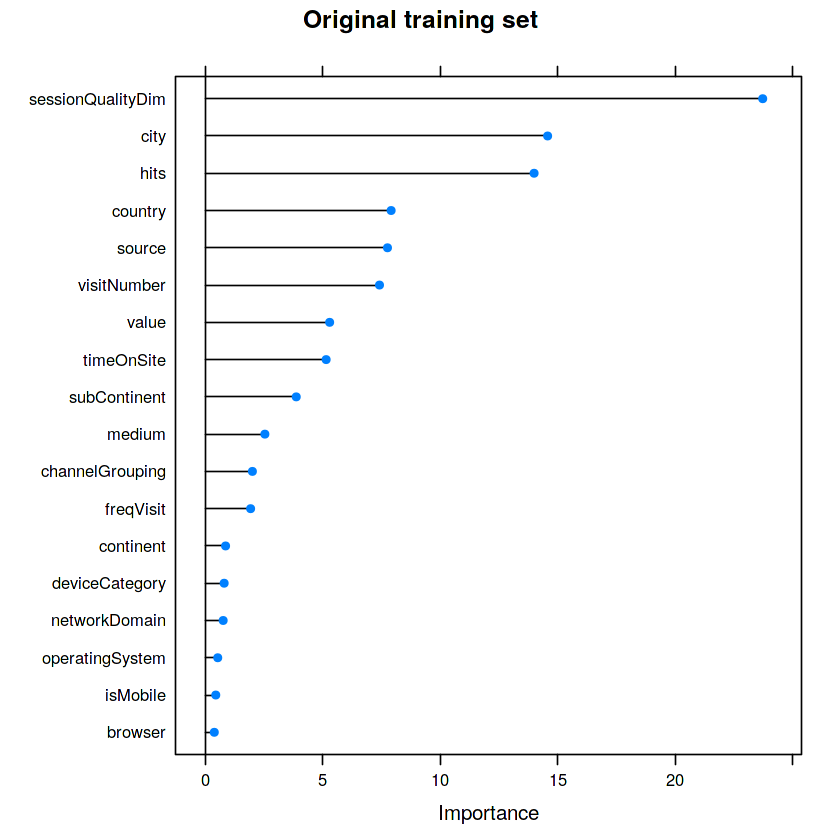

In [51]:
if(FALSE){
s.model <- readRDS("../input/tsmodels2020may17/smotesampling.rollingwin.AUC.rds")
s.model
catImp <- varImp(s.model, scale = FALSE)
plot(catImp, top = 18)

s.pred <- predict(s.model, x_test)
confusionMatrix(s.pred, y_test, positive = "Rev")
s.pred <- predict(s.model, x_test, type="prob")

s.model <- readRDS("../input/tsmodels2020may17/smotesampling.rollingwin.AUC.v2.rds")
s.model
catImp <- varImp(s.model, scale = FALSE)
plot(catImp, top = 18)

s.pred <- predict(s.model, x_test)
confusionMatrix(s.pred, y_test, positive = "Rev")
s.pred <- predict(s.model, x_test, type="prob")
}
# original training dataset
model <- readRDS("../input/tsmodels2020may17/original.rollingwin.AUC.rds")
model
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Original training set")
pred <- predict(model, x_test)
print("Original training set Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")

if(FALSE){
#plot(s.pr)
pred <- prediction(o.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)

#library(ROCR)
pred <- prediction(w.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)

pred <- prediction(s.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)

# loading package
library(precrec)
precrec_obj <- evalmod(scores = o.pred$noRev, labels = test.data$totalTransactionRevenue)
autoplot(precrec_obj)
}

Catboost 

1500131 samples
     19 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 65521, 128049, 217175, 321276, 389018, 445475, ... 
Resampling results across tuning parameters:

  depth  learning_rate  AUC        Precision  Recall     F        
  5      0.05           0.9999265  0.9998890  0.9772673  0.9883229
  5      0.10           0.9999176  0.9998793  0.9791927  0.9893223
  5      0.50           0.9187680  0.9997110  0.9840866  0.9917701
  6      0.05           0.9999293  0.9998818  0.9783451  0.9888821
  6      0.10           0.9999175  0.9998500  0.9806605  0.9900700
  6      0.50           0.9918270  0.9996262  0.9862245  0.9928253
  7      0.05           0.9999271  0.9998693  0.9796647  0.9895628
  7      0.10           0.9998946  0.9998276  0.9822815  0.9908977
  7      0.50           0.9913638  0.9995183  0.9875026  0.9934248

Tuning parameter 'iterati

[1] "catboost with weights Confusion Matrix"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 316638    155
     Rev    23980   4214
                                          
               Accuracy : 0.93            
                 95% CI : (0.9292, 0.9309)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2422          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.96452         
            Specificity : 0.92960         
         Pos Pred Value : 0.14946         
         Neg Pred Value : 0.99951         
             Prevalence : 0.01266         
         Detection Rate : 0.01221         
   Detection Prevalence : 0.08172         
      Balanced Accuracy : 0.94706         
                                          
       'Positive' Class : Rev             
            

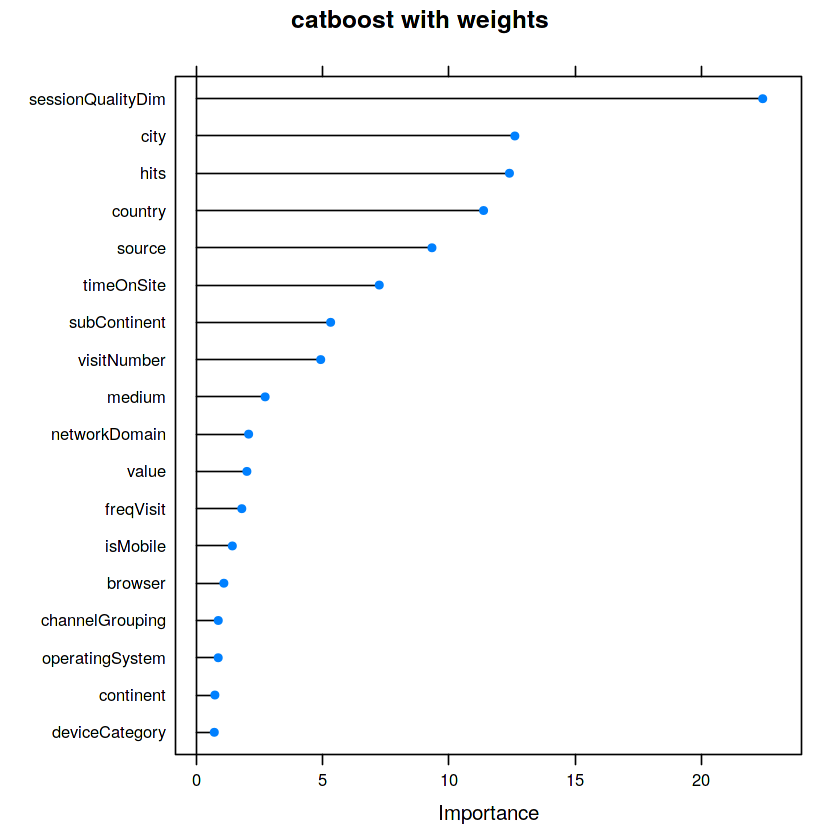

In [50]:
# weighted model
model <- readRDS("../input/tsmodels2020may17/weights.rollingwin.AUC.rds")
model
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "catboost with weights")
pred <- predict(model, x_test)
print("catboost with weights Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")

Catboost 

2490594 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 82524, 181281, 326837, 487899, 610956, 726554, ... 
Resampling results across tuning parameters:

  depth  learning_rate  AUC        Precision  Recall     F        
  5      0.05           0.9990224  0.9976762  0.9862568  0.9918445
  5      0.10           0.9994230  0.9978349  0.9907794  0.9942328
  5      0.20           0.9946278  0.9974998  0.9874385  0.9923495
  6      0.05           0.9995432  0.9980536  0.9908353  0.9943739
  6      0.10           0.9988068  0.9979259  0.9907851  0.9942737
  6      0.20           0.9977829  0.9978283  0.9911640  0.9944178
  7      0.05           0.9995288  0.9980258  0.9914841  0.9946921
  7      0.10           0.9994981  0.9980139  0.9912854  0.9945738
  7      0.20           0.9995966  0.9979822  0.9929377  0.9953980

Tuning parameter 'iterati

[1] "SMOTE1 Confusion Matrix, metric = AUC, horizon = 2"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 321154    252
     Rev    19464   4117
                                          
               Accuracy : 0.9429          
                 95% CI : (0.9421, 0.9436)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2792          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.94232         
            Specificity : 0.94286         
         Pos Pred Value : 0.17459         
         Neg Pred Value : 0.99922         
             Prevalence : 0.01266         
         Detection Rate : 0.01193         
   Detection Prevalence : 0.06835         
      Balanced Accuracy : 0.94259         
                                          
       'Positive' Class : Rev             
            

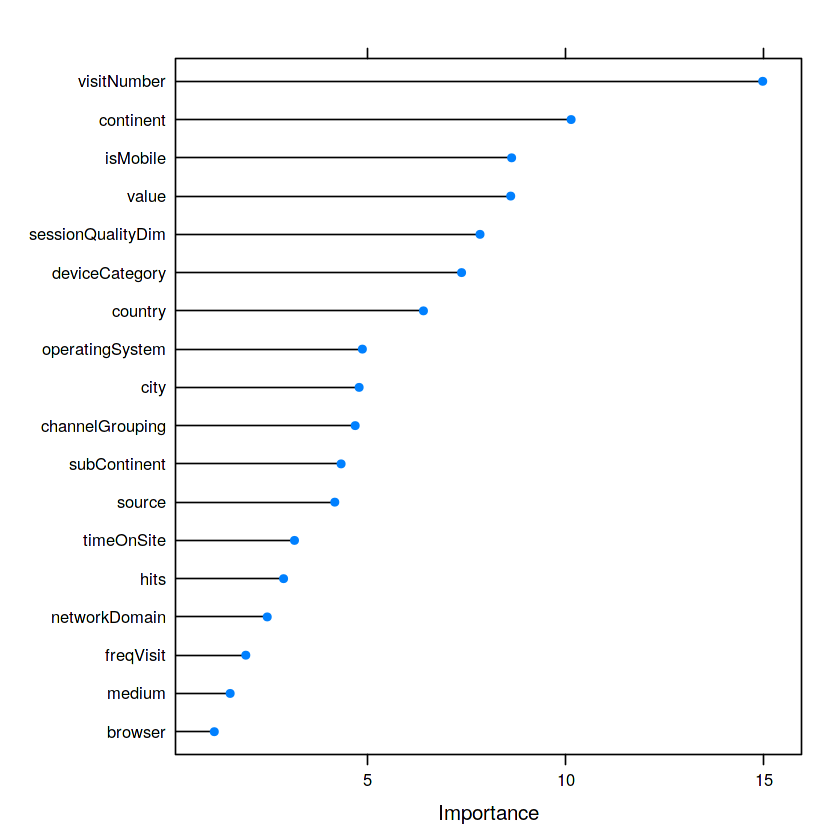

In [52]:
# smote sampling, metric = AUC, horizon = 2
model <- readRDS("../input/tsmodels2020may17/smote.catboost.rds")
model
catImp <- varImp(model, scale = FALSE, main = "SMOTE1")
plot(catImp, top = 18)

pred <- predict(model, x_test)
print("SMOTE1 Confusion Matrix, metric = AUC, horizon = 2")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")


Catboost 

2490594 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 82489, 180931, 326277, 486792, 610546, 726283, ... 
Resampling results:

  Accuracy   Kappa    
  0.9930803  0.9823987

Tuning parameter 'depth' was held constant at a value of 7
Tuning
 parameter 'rsm' was held constant at a value of 0.8
Tuning
 parameter 'border_count' was held constant at a value of 255

[1] "SMOTE2 Confusion Matrix, metric = ACC, horizon = 1, seed changed"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 324981    400
     Rev    15637   3969
                                          
               Accuracy : 0.9535          
                 95% CI : (0.9528, 0.9542)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3169          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.90845         
            Specificity : 0.95409         
         Pos Pred Value : 0.20244         
         Neg Pred Value : 0.99877         
             Prevalence : 0.01266         
         Detection Rate : 0.01150         
   Detection Prevalence : 0.05683         
      Balanced Accuracy : 0.93127         
                                          
       'Positive' Class : Rev             
            

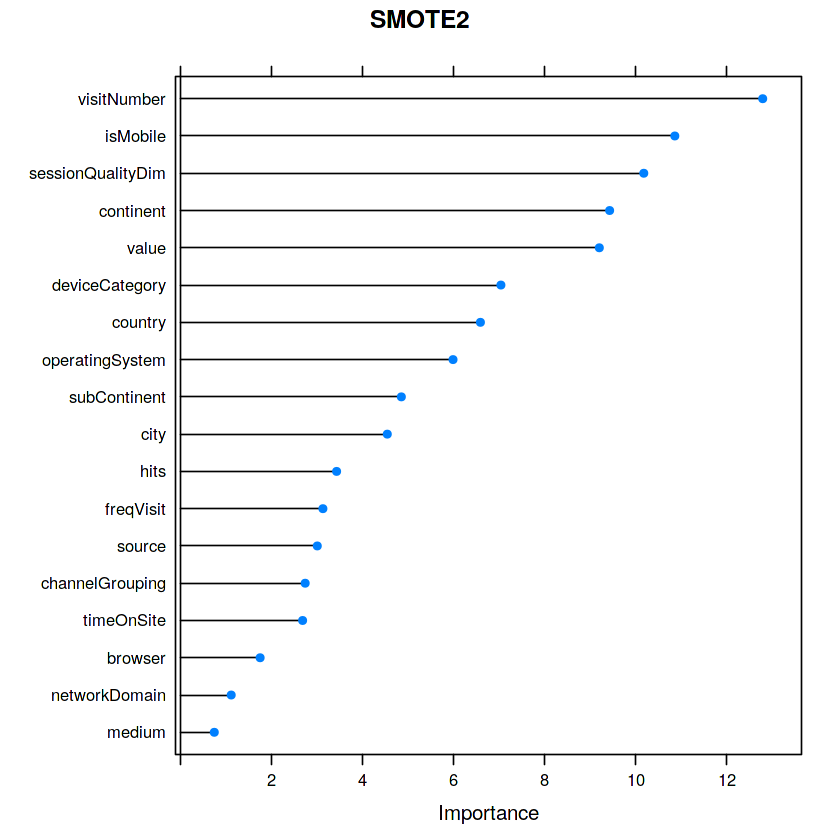

In [53]:
# smote changed seed, metric = ACC, horizon = 1
model <- readRDS("../input/tsmodels2020may18/smote.seed.catboost.rds")
model
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "SMOTE2")

pred <- predict(model, x_test)
print("SMOTE2 Confusion Matrix, metric = ACC, horizon = 1, seed changed")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")
#sum((s.pred$Rev > 0.97) == TRUE) #5803 

Catboost 

2967116 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 142421, 268559, 424689, 595958, 773577, 891678, ... 
Resampling results:

  AUC        Precision  Recall     F        
  0.9938729  0.9758929  0.9847916  0.9802159

Tuning parameter 'depth' was held constant at a value of 7
Tuning
 parameter 'rsm' was held constant at a value of 0.8
Tuning
 parameter 'border_count' was held constant at a value of 255

[1] "Oversampling Confusion Matrix"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 324243    370
     Rev    16375   3999
                                          
               Accuracy : 0.9515          
                 95% CI : (0.9507, 0.9522)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3088          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.91531         
            Specificity : 0.95193         
         Pos Pred Value : 0.19628         
         Neg Pred Value : 0.99886         
             Prevalence : 0.01266         
         Detection Rate : 0.01159         
   Detection Prevalence : 0.05906         
      Balanced Accuracy : 0.93362         
                                          
       'Positive' Class : Rev             
            

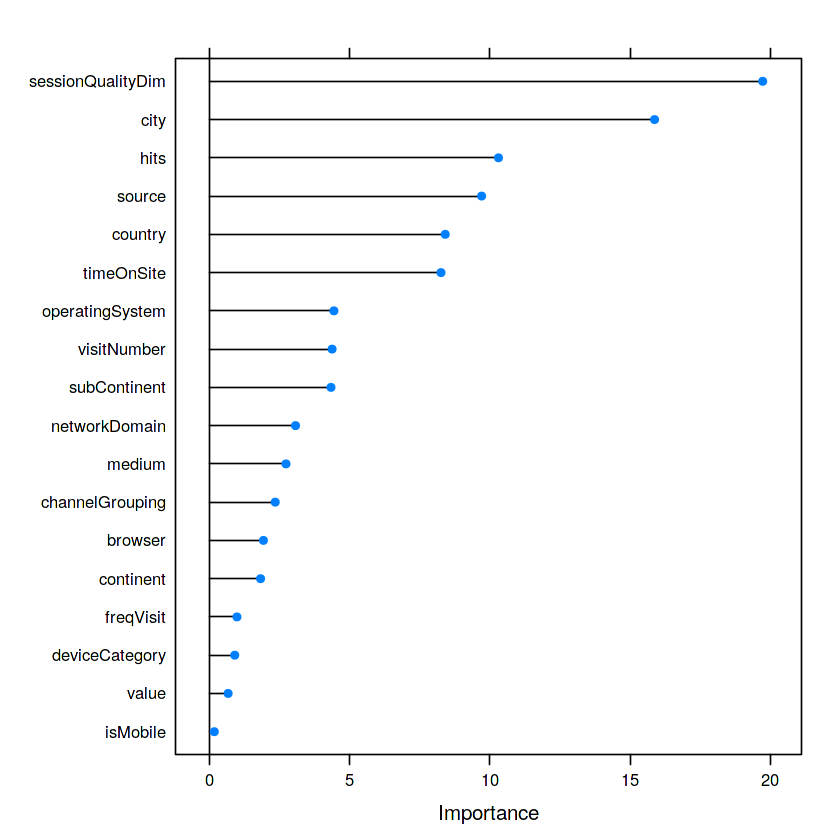

In [54]:
# oversampling
model <- readRDS("../input/tsmodels2020may17/oversample.catboost.rds")
model
catImp <- varImp(model, scale = FALSE, main = "Oversampling")
plot(catImp, top = 18)

pred <- predict(model, x_test)
print("Oversampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")

Catboost 

32950 samples
   18 predictor
    2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 1558, 2964, 4731, 6606, 8599, 9865, ... 
Resampling results:

  Accuracy   Kappa    
  0.9831175  0.9656351

Tuning parameter 'depth' was held constant at a value of 7
Tuning
 parameter 'rsm' was held constant at a value of 0.8
Tuning
 parameter 'border_count' was held constant at a value of 255

[1] "Undersampling Confusion Matrix"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 324074    428
     Rev    16544   3941
                                          
               Accuracy : 0.9508          
                 95% CI : (0.9501, 0.9515)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3026          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.90204         
            Specificity : 0.95143         
         Pos Pred Value : 0.19238         
         Neg Pred Value : 0.99868         
             Prevalence : 0.01266         
         Detection Rate : 0.01142         
   Detection Prevalence : 0.05938         
      Balanced Accuracy : 0.92673         
                                          
       'Positive' Class : Rev             
            

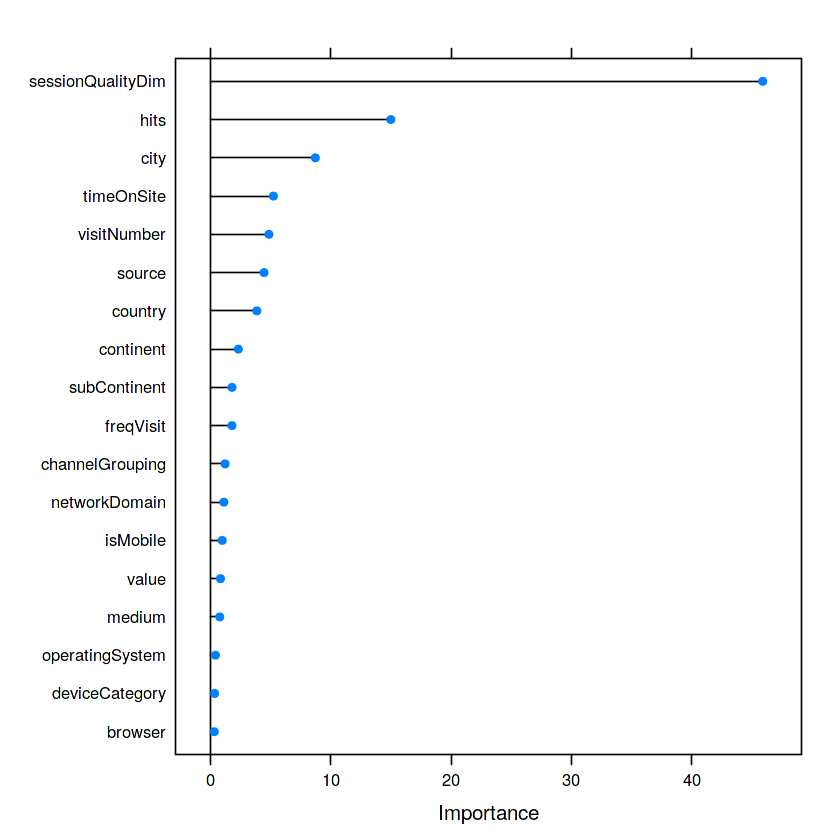

In [55]:
# undersampling
model <- readRDS("../input/tsmodels2020may18/under.catboost.rds")
model
catImp <- varImp(model, scale = FALSE, main = "Undersapmling")
plot(catImp, top = 18)

pred <- predict(model, x_test)
print("Undersampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
pred <- predict(model, x_test, type="prob")

eXtreme Gradient Boosting 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 82180, 180458, 326306, 487108, 610425, 726117, ... 
Resampling results:

  AUC        Precision  Recall     F        
  0.3995324  0.9979201  0.9914517  0.9946396

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1

[1] "xgboost Confusion Matrix"


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 301329   1123
     Rev    39289   3246
                                          
               Accuracy : 0.8829          
                 95% CI : (0.8818, 0.8839)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1182          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.742962        
            Specificity : 0.884654        
         Pos Pred Value : 0.076314        
         Neg Pred Value : 0.996287        
             Prevalence : 0.012664        
         Detection Rate : 0.009409        
   Detection Prevalence : 0.123295        
      Balanced Accuracy : 0.813808        
                                          
       'Positive' Class : Rev             
            

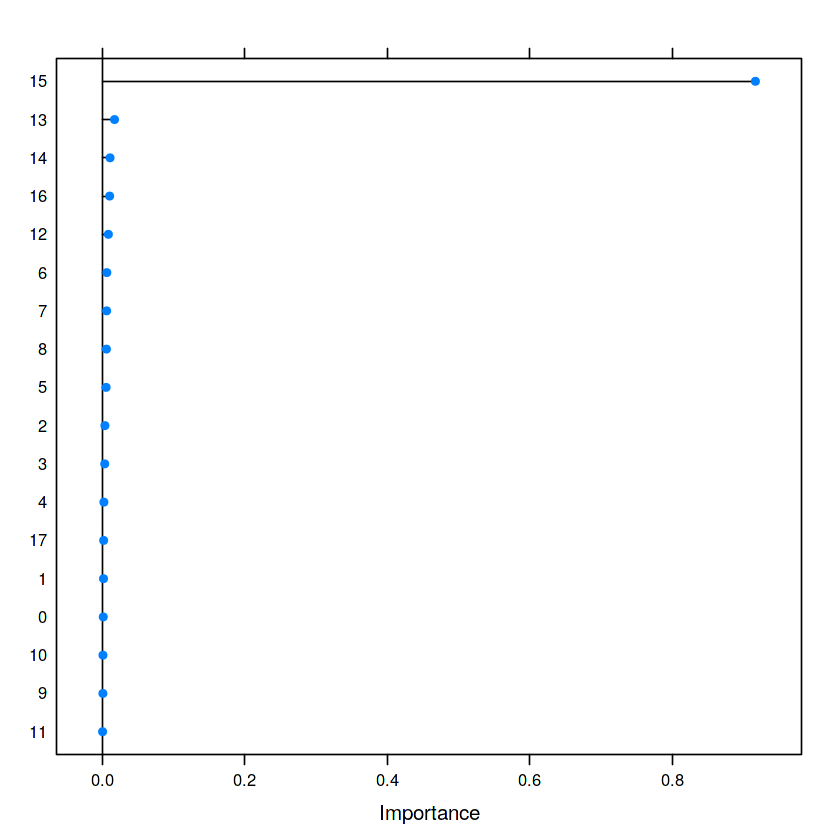

In [57]:
# xgboost classification
xgb.model <- readRDS("../input/tsmodels2020may17/xgb.rds")
xgb.model
catImp <- varImp(xgb.model, scale = FALSE, main = "xgboost Attribute Importance")
plot(catImp, top = 18)
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
print("xgboost Confusion Matrix")
confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")

In [58]:
# split test data and run the model on each subset
#---------------------------------
s.model <- readRDS("../input/tsmodels2020may18/smote.seed.catboost.rds")
s.pred <- predict(s.model, x_test)
print("training dataset...")
confusionMatrix(s.pred, y_test, positive = "Rev")
#str(test.data)
group.test.data <- split(test.data, sample(1:10, nrow(test.data), replace=T))

for (i in 1:length(group.test.data)){
    print(i)
    sub.test <- as.data.frame(group.test.data[i], col.names = names(c("channelGrouping", "browser", "operatingSystem",
                                                        "deviceCategory", "isMobile", "continent", "subContinent",
                                                        "country", "city", "networkDomain", "source", "medium",
                                                        "value", "visitNumber", "hits", "sessionQualityDim",
                                                        "timeOnSite", "totalTransactionRevenue", "ldate",
                                                        "freqVisit")))

    y_sub.test <- unlist(sub.test[c('totalTransactionRevenue')])
    x_sub.test <- select(sub.test, -c("totalTransactionRevenue"))
    s.pred <- predict(s.model, x_sub.test)
    print(confusionMatrix(s.pred, y_sub.test, positive = "Rev"))
}


[1] "training dataset..."


Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 324981    400
     Rev    15637   3969
                                          
               Accuracy : 0.9535          
                 95% CI : (0.9528, 0.9542)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3169          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.90845         
            Specificity : 0.95409         
         Pos Pred Value : 0.20244         
         Neg Pred Value : 0.99877         
             Prevalence : 0.01266         
         Detection Rate : 0.01150         
   Detection Prevalence : 0.05683         
      Balanced Accuracy : 0.93127         
                                          
       'Positive' Class : Rev             
            

[1] 1
Confusion Matrix and Statistics

          Reference
Prediction noRev   Rev
     noRev 32482    39
     Rev    1606   387
                                        
               Accuracy : 0.9523        
                 95% CI : (0.95, 0.9546)
    No Information Rate : 0.9877        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.3058        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.90845       
            Specificity : 0.95289       
         Pos Pred Value : 0.19418       
         Neg Pred Value : 0.99880       
             Prevalence : 0.01234       
         Detection Rate : 0.01121       
   Detection Prevalence : 0.05774       
      Balanced Accuracy : 0.93067       
                                        
       'Positive' Class : Rev           
                                        
[1] 2
Confu

In [71]:
# check this one run it with undersampling
# backwards selection, recursive feature elimination (RFE) using caret
str(training)
subsets <- c(5, 10, 12, 15, 18)
#model_weights <- ifelse(training$totalTransactionRevenue == "noRev",
#                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
#                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)
set.seed(10)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "timeslice",
                   index = function_ts(time.series.slices$train, temp),
                   indexOut = function_ts(time.series.slices$test, temp))

rfe.model <- rfe(x_train[, !(colnames(x_train) %in% c("ldate"))], training$totalTransactionRevenue,
                 sizes = subsets,
                 #weights = model_weights,
                 rfeControl = ctrl)

saveRDS(rfe.model, "rfe.model.rds")
rfe.model 
predictors(rfProfile)
rfProfile$fit
pred <- predict(rfProfile$fit, x_test)
#table(s.pred)
confusionMatrix(pred, y_test)


Recursive feature selection

Outer resampling method: Rolling Forecasting Origin Resampling ( held-out withfixed window) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.9815 0.9623    0.01887 0.03854         
        10   0.9823 0.9638    0.01785 0.03649        *
        12   0.9821 0.9635    0.01820 0.03716         
        15   0.9818 0.9628    0.01848 0.03778         
        18   0.9818 0.9628    0.01843 0.03767         

The top 5 variables (out of 10):
   sessionQualityDim, visitNumber, timeOnSite, city, freqVisit


[1] "sessionQualityDim" "visitNumber"       "timeOnSite"       
 [4] "city"              "freqVisit"         "hits"             
 [7] "country"           "source"            "operatingSystem"  
[10] "value"


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.51%
Confusion matrix:
      noRev   Rev class.error
noRev 16130   324  0.01969126
Rev     173 16321  0.01048866

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 313741    126
     Rev    26877   4243
                                          
               Accuracy : 0.9217          
                 95% CI : (0.9208, 0.9226)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2218          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9211          
            Specificity : 0.9712          
         Pos Pred Value : 0.9996          
         Neg Pred Value : 0.1363          
             Prevalence : 0.9873          
         Detection Rate : 0.9094          
   Detection Prevalence : 0.9098          
      Balanced Accuracy : 0.9461          
                                          
       'Positive' Class : noRev           
            

In [38]:
# binarizing, descritizing
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)
str(imbal.data)
imbal.data <- imbal.data[which(imbal.data$totalTransactionRevenue != 0),] 
#--------------------------------------------------
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
imbal.data <- select(imbal.data, -c(fullVisitorId, mday, wday, month, pageviews))
#----------------------------------------------------
# Categorical attributes level reduction...
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
imbal.data <- catTofac(cols.nam, imbal.data)
#-----------------------------------------
print("Normalizing the training set...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#-------------------------------------  
#cut(training$totalTransactionRevenue,breaks=c(-Inf,2,3, Inf), labels = c("<2", "2-3", ">3"))
#training$totalTransactionRevenue <- cut(training$totalTransactionRevenue,breaks=c(-Inf, median(training$totalTransactionRevenue), Inf), labels = c("low", "high"))
# Binarizing
imbal.data$totalTransactionRevenue <- cut(imbal.data$totalTransactionRevenue,breaks=c(-Inf, median(imbal.data$totalTransactionRevenue), Inf), labels = c("low", "high"))
table(imbal.data$totalTransactionRevenue)            
# descritizing
rev.quantile <- quantile(imbal.data$totalTransactionRevenue,  probs = c(20, 40, 60, 80)/100)
rev.quantile              
imbal.data$totalTransactionRevenue <- cut(imbal.data$totalTransactionRevenue,breaks=c(-Inf, rev.quantile, Inf), labels = c("lowest", "low", "medium", "high", "highest"))#1,2,3,4,5
table(imbal.data$totalTransactionRevenue)
#-------------------------------------
str(imbal.data)
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#-------------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
training <- cat.encode.func(training)
test.data <- cat.encode.func(test.data)
#--------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
#levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
y_train <- unlist(training[c('totalTransactionRevenue')])
#label_values <- as.integer(c("1","2","3","4","5"))
x_train <- select(training, -c("totalTransactionRevenue"))

#levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
str(y_test)
str(y_train)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
#-------------------------------------------
set.seed(123)                   
fitControl <- trainControl(method = "timeslice",
                           #classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)

# Grid Search for tuning the parameters
catboost.grid <- expand.grid(depth = c(5, 6, 7),#unbal:5, c(5, 7), #c(5,6,7),7
                    learning_rate = c(0.05, 0.1, 0.2), #c(0.5,0.1,0.05),0.5
                    iterations = 200,#200, c(100,200), #c(50,100,200),200
                    l2_leaf_reg = 3,#1e-06
                    rsm = 0.8, #c(0.8,1.0),0.8
                    #class_weights <- c(0.1, 4) # when feeding imbalanced class?
                    border_count = c(64, 128, 255))#255, c(64,128,255)) 255
print("Model fitting...")
model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
               #data = training[, !(colnames(training) %in% c("ldate"))],
               y = y_train,
               #label = label_values,
               method = catboost.caret,
               #loss_function="MultiClass",
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               tuneGrid = catboost.grid,
               #tuneLength = 3,
               #metric = "AUC",
               #metric = "F", 
               task_type = "CPU",# performance settings
               thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "desc.catboost.rds")
print("binarizing...")
# features same as smote.catboost, etc, no date data e.g., month, mday, no pageviews, freqVisit included 

'data.frame':	20863 obs. of  20 variables:
 $ channelGrouping        : Factor w/ 8 levels "(Other)","Affiliates",..: 7 5 7 7 5 7 3 7 6 7 ...
 $ ldate                  : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ visitNumber            : num  -0.336 -0.336 -0.336 -0.336 -0.336 ...
 $ browser                : Factor w/ 11 levels "Amazon Silk",..: 3 6 3 3 3 3 3 3 3 3 ...
 $ operatingSystem        : Factor w/ 7 levels "Android","Chrome OS",..: 5 6 5 5 5 5 5 5 5 5 ...
 $ isMobile               : Factor w/ 2 levels "FALSE","TRUE": 1 2 1 1 1 1 1 1 1 1 ...
 $ deviceCategory         : Factor w/ 3 levels "desktop","mobile",..: 1 3 1 1 1 1 1 1 1 1 ...
 $ continent              : Factor w/ 5 levels "Africa","Americas",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ subContinent           : Factor w/ 18 levels "Australasia",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ country                : Factor w/ 82 levels "Algeria","Anguilla",..: 80 80 80 80 80 80 80 80 80 80 ...
 $ city                   : Factor w/ 182 levels "Ah

In [39]:
bi.model <- readRDS("../input/bidesctsmodels/bi.catboost.rds") 
table(imbal.data$totalTransactionRevenue) 
bi.model 
pred <- predict(bi.model, x_test)
#table(s.pred)
confusionMatrix(pred, y_test, positive = "high")


  low  high 
10432 10431 

Catboost 

16494 samples
   18 predictor
    2 classes: 'low', 'high' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 868, 1589, 2339, 3096, 4336, 5034, ... 
Resampling results across tuning parameters:

  depth  learning_rate  border_count  Accuracy   Kappa    
  5      0.05            64           0.6499740  0.2970846
  5      0.05           128           0.6501254  0.2972193
  5      0.05           255           0.6495238  0.2962788
  5      0.10            64           0.6521144  0.3012486
  5      0.10           128           0.6488895  0.2945275
  5      0.10           255           0.6499133  0.2969699
  5      0.20            64           0.6444783  0.2857864
  5      0.20           128           0.6471554  0.2913746
  5      0.20           255           0.6436564  0.2841505
  6      0.05            64           0.6485322  0.2942786
  6      0.05           128           0.6484279  0.2941751
  6    

Confusion Matrix and Statistics

          Reference
Prediction  low high
      low   598  300
      high 1539 1932
                                          
               Accuracy : 0.5791          
                 95% CI : (0.5643, 0.5938)
    No Information Rate : 0.5109          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1472          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8656          
            Specificity : 0.2798          
         Pos Pred Value : 0.5566          
         Neg Pred Value : 0.6659          
             Prevalence : 0.5109          
         Detection Rate : 0.4422          
   Detection Prevalence : 0.7945          
      Balanced Accuracy : 0.5727          
                                          
       'Positive' Class : high            
                        

In [36]:
# descritizing
#model <- readRDS("../input/bidesctsmodels/desc.catboost.rds") 
rev.quantile              
table(imbal.data$totalTransactionRevenue)
model
pred <- predict(model, x_test)
#table(s.pred)
confusionMatrix(pred, y_test)

20%      40%      60%      80% 
17.04552 17.56407 18.03387 18.71287


 lowest     low  medium    high highest 
   4175    4171    4172    4172    4173 

Catboost 

16494 samples
   18 predictor
    5 classes: 'lowest', 'low', 'medium', 'high', 'highest' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 868, 1589, 2339, 3096, 4336, 5034, ... 
Resampling results across tuning parameters:

  depth  learning_rate  border_count  Accuracy   Kappa    
  5      0.05            64           0.3108469  0.1362160
  5      0.05           128           0.3137726  0.1399992
  5      0.05           255           0.3135913  0.1396591
  5      0.10            64           0.3151126  0.1411285
  5      0.10           128           0.3119629  0.1374102
  5      0.10           255           0.3163854  0.1427118
  5      0.20            64           0.3123352  0.1371966
  5      0.20           128           0.3108896  0.1353254
  5      0.20           255           0.3106543  0.1354231
  6      0.05            64           0.3118803  0.1374562
  6      0.05           128        

Confusion Matrix and Statistics

          Reference
Prediction lowest low medium high highest
   lowest     400 358    311  208     115
   low         40  33     49   35      21
   medium     164 232    229  189     146
   high         0   3      2    2       1
   highest    164 270    340  471     586

Overall Statistics
                                          
               Accuracy : 0.2861          
                 95% CI : (0.2727, 0.2998)
    No Information Rate : 0.2131          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1133          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: lowest Class: low Class: medium Class: high
Sensitivity                0.52083   0.036830       0.24597   0.0022099
Specificity                0.72452   0.958249       0.78738   0.9982679
Pos Pred Value             0.28736   0.185393    

In [ ]:
# Classification using xgboost
#----------------------------------
#----------------------------------
#str(training)
#levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
x_train = xgb.DMatrix(as.matrix(training %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_train = training$totalTransactionRevenue
#levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
x_test = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_test = test.data$totalTransactionRevenue
#str(x_train)
xgb_trcontrol = trainControl(
  method = "timeslice",
  classProbs = TRUE,
  summaryFunction = prSummary,
  #savePredictions = TRUE,
  index = function_ts(time.series.slices$train, temp),
  indexOut = function_ts(time.series.slices$test, temp),
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
xgbGrid <- expand.grid(nrounds = 100,#c(100,200),  # this is n_estimators in the python code
                       max_depth = c(10, 20, 25),#c(10, 15, 20, 25), 7
                       colsample_bytree = c(0.5, 1),#seq(0.5, 0.9, length.out = 5),
                       ## The values below are default values in the sklearn-api. 
                       eta = c(0.1, 0.2),#0.2, 0.1
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1
                      )
# More classification models are being generated: 
# fixed vs rolling window, original, weighted and sampled datasets
print("XGBoost Model fitting...")
set.seed(0) 
xgb.model.2 = train(
  x_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  #tuneLength = 2,
  method = "xgbTree",
  metric = "AUC",
  nthread = 4  
)
saveRDS(xgb.model, "xgb2.rds")

xgb.model <- readRDS("../input/tsmodelxgb/xgb.rds")
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
#table(s.pred)
confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")
#sum((xgb.pred$Rev > 0.9) == TRUE)

In [77]:
# Random forest: did not complete due to memory limit
set.seed(123)
training$ldate <- as.numeric(training$ldate)

#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 4500, perc.under=200)
#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6500, perc.under=136)
smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6000, perc.under=150)
smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)
table(training$totalTransactionRevenue)
table(smote.train$totalTransactionRevenue)
print(prop.table(table(training$totalTransactionRevenue)))
print(prop.table(table(smote.train$totalTransactionRevenue)))

cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
#training <- cat.encode.func(training)
training <- cat.encode.func(smote.train)
#training <- cat.encode.func(ovun.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)


training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
#y_train <- unlist(training[c('totalTransactionRevenue')])
#x_train <- select(training, -c("totalTransactionRevenue"))
#levels(validation$totalTransactionRevenue) <- c("noRev", "Rev")
#y_valid <- unlist(validation[c('totalTransactionRevenue')])
#x_valid <- select(validation, -c("totalTransactionRevenue"))

levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
#y_test <- unlist(test.data[c('totalTransactionRevenue')])
#x_test <- select(test.data, -c("totalTransactionRevenue"))
#str(x_train)
#str(x_valid)
#str(x_test)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   

fitControl <- trainControl(method = "timeslice",
                           #classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           search="grid",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)
#control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")
print("Random Forest...")
training <- select(training, -ldate)
gc()
set.seed(123)
tunegrid <- expand.grid(mtry=c(1:10))
model <- train(totalTransactionRevenue~., data=training, method="rf",
               #metric="AUC", 
               tuneGrid=tunegrid, 
               trControl=fitControl)

saveRDS(model, "rf.model.rds")
print(rf_gridsearch)
plot(rf_gridsearch)

[1] "Random Forest..."


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7544233,403.0,14557236,777.5,55057782,2940.5
Vcells,197225087,1504.8,595786475,4545.5,930624368,7100.2


In [87]:
# Data preparation for regression
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)
#--------------------------------------------------
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
# Only NetworkDoamin as it contains lots of very low frequnecy data results in many levels
print("Reducing categorical attributes' levels...")
#cols.nam <- c("browser", "networkDomain", "country", "source")
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        #df[,x[i]] <- fct_lump(df[,x[i]], p = 0.01, w = NULL, other_level = "(Other)")
        # We can go with n = ... to keepp more levels in the analysis
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
#dataset <- catTofac(cols.nam, dataset)
imbal.data <- catTofac(cols.nam, imbal.data)
# Not including features extracted from date for now
#library(dplyr)
imbal.data <- select(imbal.data, -c(fullVisitorId, month, mday, wday))
str(imbal.data)
#-----------------------------------------
print("Normalizing the dataset...")
cols.nam <- c("visitNumber", "hits", "pageviews", "timeOnSite", "sessionQualityDim")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#training <- dataset
#-----------------------------------------
print("Splitting dataset into training and test...")
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#-------------------------------------
#Data split
training <- training[which(training$totalTransactionRevenue != 0),] 
#training <- dataset %>%
#    filter(ldate < as.Date("2018-05-01"))
#validation <- dataset %>%
#    filter(ldate >= as.Date("2017-01-01"))
#------------------------------------
# Addressing imbalanced class: maybe we can do this in trainControl again?
if(FALSE){
set.seed(1)
print("Addressing imbalanced numeric class...")
#rel <- matrix(c(10, 1, 0, 15, 0, 0, 20, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
#smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
#                        C.perc = list(10, 1), k=5, repl=FALSE, p = 2)
#-------go with this one for now
training$ldate <- as.numeric(training$ldate)                 
rel <- matrix(c(13, 1, 0, 17, 0, 0, 23, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
                        C.perc = list(900, 1, 20), k = 5, repl=FALSE, p = 2)

smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)

plot(sort(training$totalTransactionRevenue))
plot(sort(smote.train$totalTransactionRevenue))
}
#-----------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "source", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue", "ldate")])
    return(df)
}
#training <- cat.encode.func(smote.train)
#training <- cat.encode.func(smote.train)
training <- cat.encode.func(training)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
y_train <- unlist(training[c('totalTransactionRevenue')], use.names = FALSE)
x_train <- select(training, -c("totalTransactionRevenue"))
#y_valid <- unlist(validation[c('totalTransactionRevenue')], use.names = FALSE)
#x_valid <- select(validation, -c("totalTransactionRevenue"))

y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#-------------------------------------
# Preparing dataset for timeSlices
str(training)
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
# Creating time slices
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}
#-------------------------------------------          
fitControl <- trainControl(method = "timeslice",
                           #sampling = "smote",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)                           
)
print("Fitting the regression model...")                   
set.seed(123)
grid <- expand.grid(depth = 5,# c(5, 7), #c(5,6,7),7
                    learning_rate = 0.2, #c(0.05, 0.1, 0.2), #c(0.2,0.1,0.05),0.05
                    iterations = 200, #c(50,100,200),200
                    l2_leaf_reg = 3,
                    rsm = 0.8, #c(0.8,1.0),0.8
                    border_count = 255)#c(64, 255))#c(64,128,255)) , 255
                   
reg.model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
                   y = y_train,
                   method = catboost.caret,
                   trControl = fitControl,
                   tuneGrid = grid,
                   task_type = "CPU",
                   thread_count = 4
              )
                   
#saveRDS(reg.model, "smote.reg.model.rds")
reg.model

[1] "Splitting dataset into training and test..."


In [ ]:
#reg.model <- readRDS("../input/mylatestmodels/original.rollingwin.AUC.reg.rds")
#smote.reg.model <- readRDS("../input/tsmodelsmotereg/smote2.rollingwin.reg.rds")
#smote.reg.model <- readRDS("../input/mylatestmodels/original.fixedwin.AUC.reg.rds")                   
#pred_reg <- predict(reg.model, x_test)  
#w.model <- readRDS("../input/mylatestmodels/weights.rollingwin.AUC.rds")
#w.pred <- predict(w.model, x_test, type="prob")
str(test.data)
head(s.pred$Rev)
test.data$Rev <- s.pred$Rev
x_test_new <- test.data %>%
filter(Rev > 0.95)
dim(x_test_new) 

y_test <- unlist(x_test_new[c('totalTransactionRevenue')])
x_test <- select(x_test_new, -c("totalTransactionRevenue"))
                 
reg.pred <- predict(reg.model, x_test)
s.reg.pred <- predict(smote.reg.model, x_test)
head(s.reg.pred)
# we do not have revenues for those time periods Dec 2018 to Jan 2019 to calculate RMSE and R2
RMSE(reg.pred, y_test)
R2(reg.pred, y_test)
RMSE(s.reg.pred, y_test)
R2(s.reg.pred, y_test)

smote.reg.model
temp <- test.data %>% select(totalTransactionRevenue) %>%
                   filter(totalTransactionRevenue>0)
#par(mfrow=c(1,2))
plot(temp$totalTransactionRevenue, type="l")
plot(reg.pred, type="l")
plot(s.reg.pred, type="l")
str(s.reg.pred)
temp <- as.data.frame(s.reg.pred)
str(temp)
temp$s.reg.pred[which(temp$s.reg.pred < 0)] <- 0
temp2 <- temp %>%
filter(temp$s.reg.pred > 1)
plot <- plot(temp2$s.reg.pred, type="l")
sum(s.reg.pred > )      
#require(gridExtra)
#plot1 <- qplot(1)
#plot2 <- qplot(1)
#grid.arrange(plot1, plot2, ncol=2)
# We can do different regression models e.g., original sampled datasets, fixed vs rolling window

In [ ]:
# catboost regression performance
test.data <- test.data %>% filter(totalTransactionRevenue != 0)
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
reg.model
reg.pred <- predict(reg.model, x_test)
RMSE(reg.pred, y_test)
R2(reg.pred, y_test)

plot(test.data$totalTransactionRevenue, type="l", main = "Actual Revenues")
plot(reg.pred, type="l", main = "Predicted Revenues")

eXtreme Gradient Boosting 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 868, 1589, 2339, 3096, 4336, 5034, ... 
Resampling results:

  RMSE      Rsquared   MAE      
  1.043339  0.1546415  0.8063645

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 parameter 'min_child_weight' was held constant at a value of 1

Tuning parameter 'subsample' was held constant at a value of 1

[1] 1.429552

[1] 0.06141166

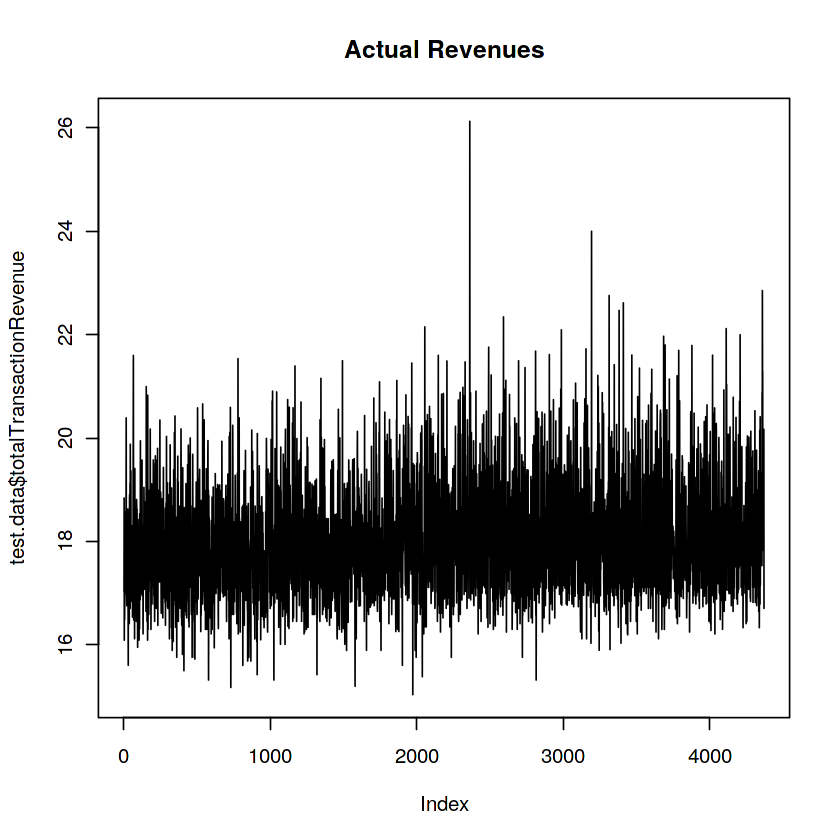

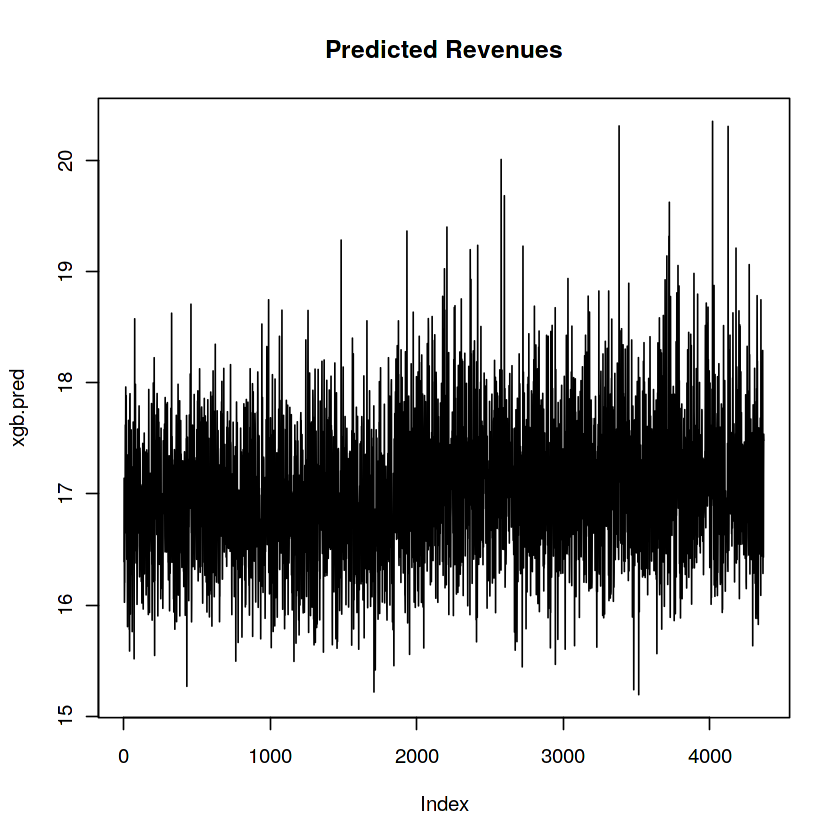

In [85]:
# Regression using xgboost
#----------------------------------
#----------------------------------
#str(training)
#levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
x_train = xgb.DMatrix(as.matrix(training %>% select(-c(totalTransactionRevenue, ldate))))
y_train = training$totalTransactionRevenue
#levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
#test.data <- test.data %>% filter(totalTransactionRevenue != 0)
x_test = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test = test.data$totalTransactionRevenue
#str(x_train)
xgb_trcontrol = trainControl(
  method = "timeslice",
  #classProbs = TRUE,
  #summaryFunction = prSummary,
  #savePredictions = TRUE,
  index = function_ts(time.series.slices$train, temp),
  indexOut = function_ts(time.series.slices$test, temp),
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
xgbGrid <- expand.grid(nrounds = 100,#c(100,200),  # this is n_estimators in the python code
                       max_depth = 10,#c(10, 20, 25),#c(10, 15, 20, 25), 7
                       colsample_bytree = 0.5, #c(0.5, 1),#seq(0.5, 0.9, length.out = 5),
                       ## The values below are default values in the sklearn-api. 
                       eta = 0.2, #c(0.1, 0.2),#0.2, 0.1
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1
                      )
# More classification models are being generated: 
# fixed vs rolling window, original, weighted and sampled datasets
print("XGBoost Model fitting...")
set.seed(0) 
xgb.model = train(
  x_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  #tuneLength = 2,
  method = "xgbTree",
  #metric = "AUC",
  nthread = 4  
)
#saveRDS(xgb.model, "xgb2.rds")

#xgb.model <- readRDS("../input/tsmodelxgb/xgb.rds")
xgb.model
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
#confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
#xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")
#sum((xgb.pred$Rev > 0.9) == TRUE)

#smote2.xgb.pred <- predict(smote.xgb.fixe.model, x_test)

RMSE(xgb.pred, y_test.xgb)
R2(xgb.pred, y_test.xgb)
#RMSE(smote.xgb.pred, y_test)
#R2(smote.xgb.pred, y_test)
#RMSE(smote2.xgb.pred, y_test)
#R2(smote2.xgb.pred, y_test)

plot(test.data$totalTransactionRevenue, type="l", main = "Actual Revenues")
plot(xgb.pred, type="l", main = "Predicted Revenues")
#plot(smote2.xgb.pred, type="l")

In [ ]:
# feature selection using glmnet
#----------------------------
#----------------------------
#----------------------------
library(glmnet)
#library(Matrix)
 
# Dealing with categorical features
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
                 "hour", "mday", "wday", "month")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "pageviews","sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
#training <- cat.encode.func(training)
training <- cat.encode.func(smote.train)
#training <- cat.encode.func(ovun.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
# almost 80% for training and 20% for testing
dim(training)
dim(test.data)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
#x_train = matrix(training %>% select(-c(totalTransactionRevenue)))
#x_train = training %>% select(-c(totalTransactionRevenue))
#y_train = training$totalTransactionRevenue
#str(x_train)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
     
#x_train = matrix(training %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId)))
fitControl <- trainControl(method = "timeslice",
                           classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)
tuneGrid=expand.grid(
               alpha=1,
               lambda=seq(0, 100, by = 0.1))
print("lasso model fitting...")
model <- train(totalTransactionRevenue ~ .,
               data = training[, !(colnames(training) %in% c("ldate", "fullVisitorId"))], 
               #y = y_train,
               method = "glmnet",
               #alpha = 1,
               #control = boost_control(mstop = 100),
               #mstop = 2000,
               #tuneLength=5, 
               #mstop = 100, 
               #nu = 0.1,
               #center=FALSE, 
               #family=binomial(),
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               tuneGrid = tuneGrid,
               #tuneLength = 3,
               metric = "AUC",
               family="binomial"
               #metric = "F", 
               #task_type = "CPU",# performance settings
               #thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "glmnet.rds")

In [ ]:
# feature selection on SMOTE model using MASS library
library(MASS)
step.model <- stepAIC(s.model, direction = "both", 
                      trace = FALSE)
summary(step.model)
str(training)
library(leaps)
models <- regsubsets(totalTransactionRevenue~., data = training[, !(colnames(training) %in% c("ldate", "fullVisitorId"))]
                     , nvmax = 18, #number of features
                     method = "seqrep")
summary(models)

In [ ]:
library(clustMixType)
temp <- select(imbal.data, -c("ldate", "fullVisitorId", "totalTransactionRevenue"))
kmc <- kproto(temp, 2, lambda = NULL, iter.max = 100,
  nstart = 1, na.rm = TRUE, keep.data = FALSE, verbose = FALSE)

In [ ]:
#library(mboost)
library(glmnet)
library(Matrix)
set.seed(123) 
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
#training <- cat.encode.func(smote.train)
training <- cat.encode.func(training)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
# almost 80% for training and 20% for testing
dim(training)
dim(test.data)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
x_train = matrix(training %>% select(-c(totalTransactionRevenue)))
y_train = training$totalTransactionRevenue
str(x_train)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
     
#x_train = matrix(training %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId)))
fitControl <- trainControl(method = "timeslice",
                           classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)
model_weights <- ifelse(training$totalTransactionRevenue == "0",
                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)
print("glm model fitting...")
model <- train(class ~ y_train,
               data = x_train, 
               #y = y_train,
               method = "glmnet",
               #alpha = 1,
               #control = boost_control(mstop = 100),
               #mstop = 2000,
               #tuneLength=5, 
               #mstop = 100, 
               #nu = 0.1,
               #center=FALSE, 
               #family=binomial(),
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               #tuneGrid = catboost.grid,
               #tuneLength = 3,
               metric = "AUC"
               #metric = "F", 
               #task_type = "CPU",# performance settings
               #thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "glmnet.rds")

In [ ]:
#library(forcats)
library(glmnet)
library(class)
library(gmodels)
#TODO:change totalTransaction to numeric and run the model
str(training)
rose.train <- rose.train %>%
    select(-country, -date, -visitStartTime, -fullVisitorId, -visitId)

x <- model.matrix(totalTransactionRevenue~., training)[,-13]
head(x)
y=training$totalTransactionRevenue
# Note alpha=1 for lasso only and can blend with ridge penalty down to
# alpha=0 ridge only.
#Find the optimal value of lambda that minimizes the cross-validation error
cv.lasso <- cv.glmnet(x, y, alpha = 1, family = "binomial")
#best Lasso model with lambda = lambda.min, cross validation
model <- glmnet(x, y, alpha = 1, family = "binomial", lambda = cv.lasso$lambda.min)
# Display regression coefficients, important attributes
#coef(model)
coefs = coef(model)[,1]
sort(abs(coefs), decreasing = T)

# Make prediction on test data
imbal.test <- imbal.test %>%
    select(-country, -date, -visitStartTime, -fullVisitorId, -visitId)

x.test <- model.matrix(totalTransactionRevenue~., imbal.test)[,-13]
y.test <- imbal.test$totalTransactionRevenue

pred <- predict(model, s = cv.lasso$lambda.min, newx = x.test)
final <- cbind(y.test, pred)
# Checking the first six obs
head(final)

CrossTable(x=y.test, y=pred, prop.chisq=FALSE)
#performance of the model, sum of square for both training and test
#############################################
library(clustMixType)
data.rose <- data.rose[-c(2:4)]
str(data.rose)
kproto(data.rose, 5)
clprofiles(kpres, x)